# Faster R-CNN experiments
This file contains experiments for my Faster R-CNN implementation. To access GPUs/TPUs, I ran this file in Google Colaboratory.

To pull from the GitHub repository in Colab:
```
%cd drive/MyDrive/Conservation\ Research/Code/counting-cranes
!git add .
!git stash
!git pull
```
----

In [3]:
#Will have to restart runtime after running this cell!
!pip install -r "/content/drive/MyDrive/Conservation Research/Code/counting-cranes/requirements.txt"

     |████████████████████████████████| 2.2MB 7.2MB/s 
     |████████████████████████████████| 17.4MB 174kB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 15.3MB 207kB/s 
     |████████████████████████████████| 11.6MB 39.7MB/s 
     |████████████████████████████████| 808kB 50.9MB/s 
     |████████████████████████████████| 8.3MB 45.3MB/s 
     |████████████████████████████████| 38.2MB 1.2MB/s 
     |████████████████████████████████| 122kB 58.7MB/s 
     |████████████████████████████████| 829kB 42.8MB/s 
     |████████████████████████████████| 276kB 50.2MB/s 
     |████████████████████████████████| 10.6MB 174kB/s 
     |████████████████████████████████| 317kB 57.8MB/s 
     |████████████████████████████████| 59.9MB 50kB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 1.3MB 41.2MB/s 
     |████████████████████████████████| 143kB 58.2MB/s 
     |████████████████████████████████| 296kB 55.1

In [1]:
import json

config = json.load(open('/content/drive/MyDrive/Conservation Research/Code/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_colab']
CODE_FP = config['code_filepath_colab']
MODEL_SAVE_FP = config['model_saves_filepath_colab']
SEED = config['random_seed']
HYPERPARAMETERS = config['faster_rcnn_params']

In [2]:
import sys
import os
sys.path.append(CODE_FP) 
sys.path.append(os.path.join(CODE_FP, 'object_detection'))

from faster_rcnn_model import *
from bird_dataset import *

import torch
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

## Model training
If the Colab runtime disconnects, you'll have to load from a post-epoch `PyTorch Lightning` model save.

In [3]:
#Setting our random seed for all operations (PyTorch, numpy, python.random)
#  especially important if Colab exits the runtime... ensures that we get the same train/val/test split!
seed_everything(SEED);

Global seed set to 1693


In [4]:
#Creating a dataset and subsetting into train/validation/test splits - run the "seed_everything" directly before this cell!
#  TODO: change this once you have tiling w/o overlap implemented!
bird_dataset = BirdDataset(root_dir = DATA_FP, transforms = get_transforms(train = True), num_tiles = 10, max_neg_examples = 3)

indices = torch.randperm(len(bird_dataset)).tolist()
dataset_train = torch.utils.data.Subset(bird_dataset, indices[ : 24]) #24 images in train
dataset_val = torch.utils.data.Subset(bird_dataset, indices[24 : 28]) #4 images in val
dataset_test = torch.utils.data.Subset(bird_dataset, indices[28 : ]) #6 images in test

In [8]:
#Wrapping our train/validation/test sets in DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size = HYPERPARAMETERS['batch_size'], shuffle = True, collate_fn = collate_w_tiles) 
dataloader_val = DataLoader(dataset_val, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_w_tiles) 
dataloader_test = DataLoader(dataset_test, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_w_tiles) 

In [14]:
#Instantiating the pre-trained model and wrapping it in PyTorch Lightning class
model = get_faster_rcnn(num_classes = 2) #class 0 is reserved for background (may not be necessary) + class 1 is bird class
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'], iou_threshold = HYPERPARAMETERS['iou_threshold_EVALUATION'])
pl_model; #checking out the model summary - delete ";" if you want to see it!

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [15]:
#Setting up logger 
logging_directory = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'evaluation')
logger = CSVLogger(logging_directory, name = 'initial_training_6.8.2021') #REMEMBER: change this when you shift experiments!

In [16]:
#Training the model w/early stopping on "Validation_AP" (remember: we only have one class so this is equivalent to mAP)
checkpoint_dir = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'trainer_checkpoints')

early_stopping_callback = EarlyStopping(monitor = 'Validation_AP', patience = 10, mode = 'max') #makes it so that we don't have to babysit the model as much

trainer = Trainer(gpus = 1, max_epochs = 100, callbacks = [early_stopping_callback], default_root_dir = checkpoint_dir, logger = logger) 
trainer.fit(pl_model, train_dataloader = dataloader_train, val_dataloaders = dataloader_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Global seed set to 1693


In [17]:
#Saving the model
save_name = 'faster_rcnn_random_tiling_6.8.2021.pth'
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name))

## Qualitatively inspecting predictions from the trained model
To avoid memory errors, we have to save and load the model. Make sure to restart the runtime!

In [18]:
#Loading the model
save_name = 'faster_rcnn_random_tiling_6.8.2021.pth'
model = get_faster_rcnn(num_classes = 2) 
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate']) 

In [20]:
#Attempting a forward pass
images, targets, _, _ = next(iter(dataloader_test))
preds = pl_model(images)

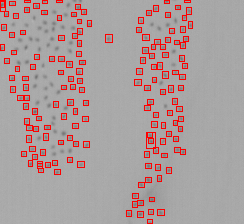

In [38]:
#Plotting an image and predicted bboxes
#  TODO: might need NMS on the prediction outputs (maybe change "box_nms_thresh" argument in "get_faster_rcnn")
#  TODO: maybe make a wrapper function to visualize predictions...
index = 7
img = np.moveaxis(images[index].numpy(), 0, -1) * 255
bboxes = preds[index]['boxes'].tolist()

pil_img = Image.fromarray(img.astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in bboxes:
    draw.rectangle(b, outline = 'red', width = 1)
pil_img

In [39]:
#Checking counts
print(f'We predicted {len(bboxes)} birds and there are actually {len(targets[index]["boxes"])} birds in this image')

We predicted 158 birds and there are actually 211 birds in this image


## Model testing

In [ ]:
#Loading the model
save_name = 'faster_rcnn_random_tiling_6.8.2021.pth'
model = get_faster_rcnn(num_classes = 2) 
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'], iou_threshold = HYPERPARAMETERS['iou_threshold_EVALUATION'])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [41]:
#Using the saved model and the test set to evaluate (via AP)

# logging_directory = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'evaluation')
# logger = CSVLogger(logging_directory, name = 'first_experiment')

trainer = Trainer(gpus = 1) #IF YOU WANT TO LOG: add the logger in here and uncomment above...
results = trainer.test(pl_model, test_dataloaders = dataloader_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test_AP': 0.6501970262070015, 'Test_FP': 1032.0, 'Test_TP': 3970.0}
--------------------------------------------------------------------------------


In [46]:
#Inspecting results
print(f'We ended up with a test Average Precision of {round(results[0]["Test_AP"], 3)}')

We ended up with a test Average Precision of 0.65
